In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from NetEmbs import *
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["figure.figsize"] = [20,10]

In [3]:
embs = pd.read_pickle("model/tmps/tmp_dataMarcel.pkl")

In [37]:
cur_path= "model/"+WORK_FOLDER[0]+WORK_FOLDER[1]

In [3]:
embs_bad = pd.read_pickle("model/2_walks30_pressure30_window3/TFsteps200000batch64_emb32/cache/Embeddings.pkl")

In [5]:
embs_bad.head()

,ID,Emb,GroundTruth
0,1,"[0.12368746, 0.161482, 0.28400204, -0.1822038,...",Purchase
1,3,"[0.115511775, 0.03801798, -0.06206809, -0.2260...",Sales 21 btw
2,4,"[-0.47322965, -0.04450774, -0.008095294, -0.17...",Cost of Sales
3,5,"[-0.21242754, -0.23674373, 0.053790133, 0.0479...",Fixed Assets
4,6,"[0.1002198, 0.18796788, -0.201984, 0.20154962,...",Tax disbursement


Collections


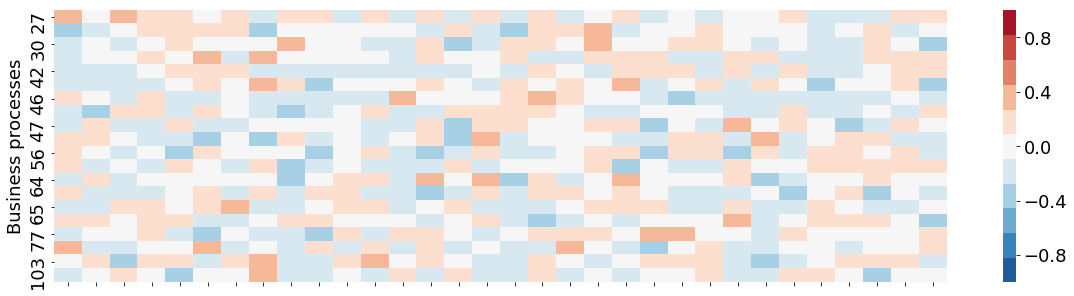

/Users/lex/anaconda3/envs/DL/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Cost of Sales


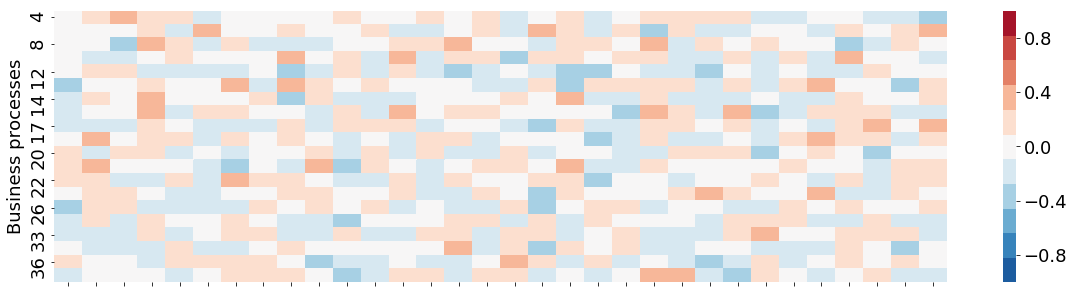

Depreciation


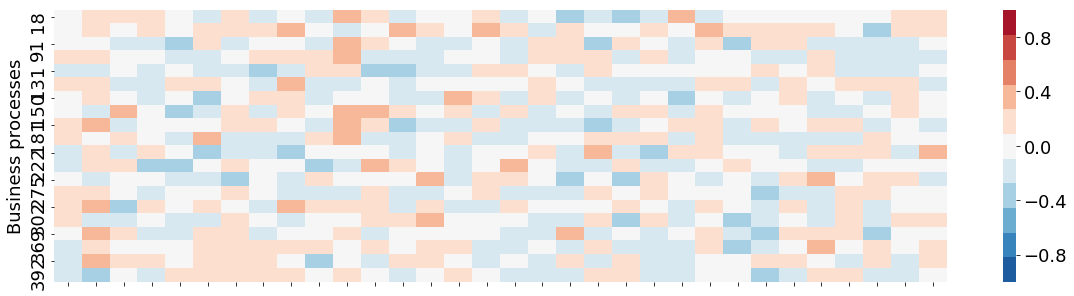

Fixed Assets


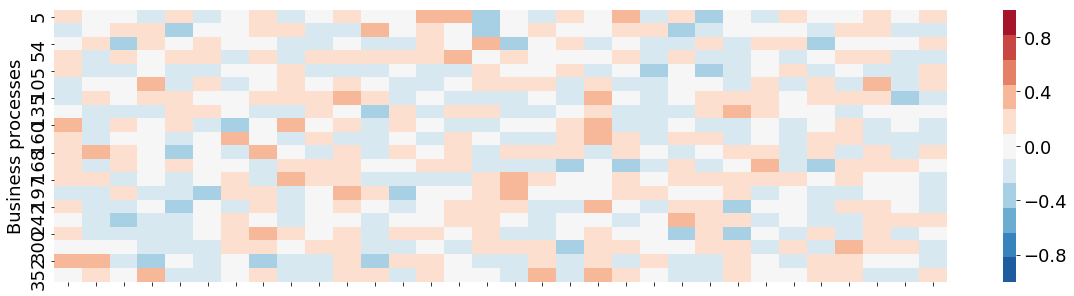

Payroll


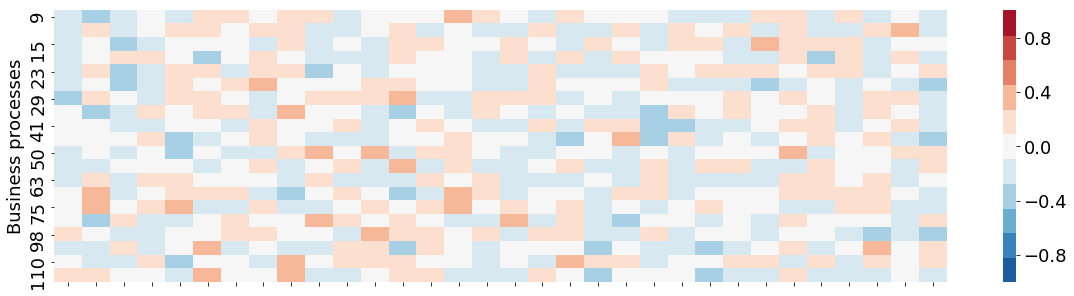

Payroll Disbursement
Not enough samples...
Purchase


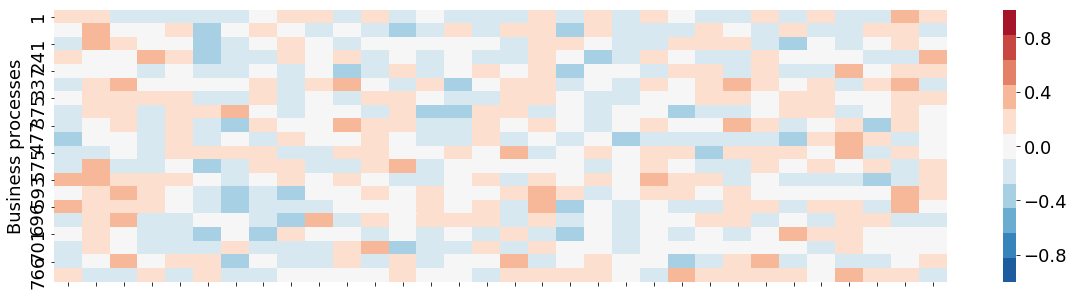

Sales 21 btw


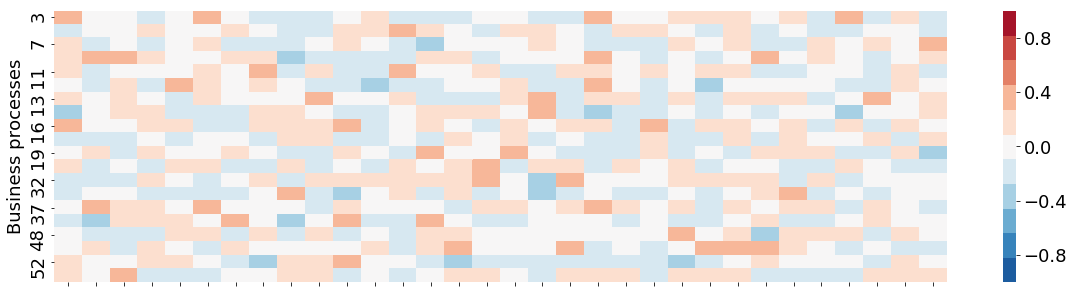

Sales 6 btw


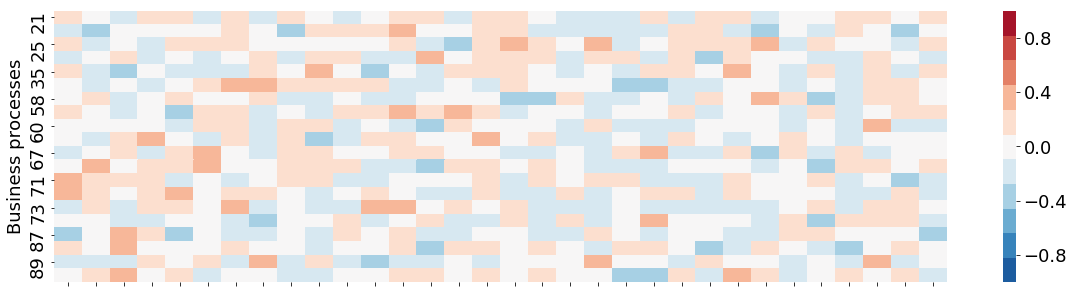

Tax disbursement
Not enough samples...


In [50]:
dims = 20
ns = 11
sm_embs_bad = pd.DataFrame(columns=list(embs)+["Legend"])
for name, group in embs_bad.groupby("GroundTruth"):
    print(name)
    if group.shape[0] > 3:
        plt.figure(figsize=(20, 5))
        sns.heatmap(list(group["Emb"].values[:dims]), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 11))
        frame1 = plt.gca()
        frame1.axes.set_xlabel('')
        frame1.axes.set_ylabel('Business processes')
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels(list(group["ID"].values[:dims]))
        plt.show()
        app = group.head(ns).copy()
#         app["Legend"] = np.array([None, None, group["GroundTruth"].values[0], None, None])
        sm_embs_bad = sm_embs_bad.append(app, sort=False).append(pd.DataFrame({"ID": 0, "Emb": [[-2]*32], "GroundTruth": None}))
    else:
        print("Not enough samples...")

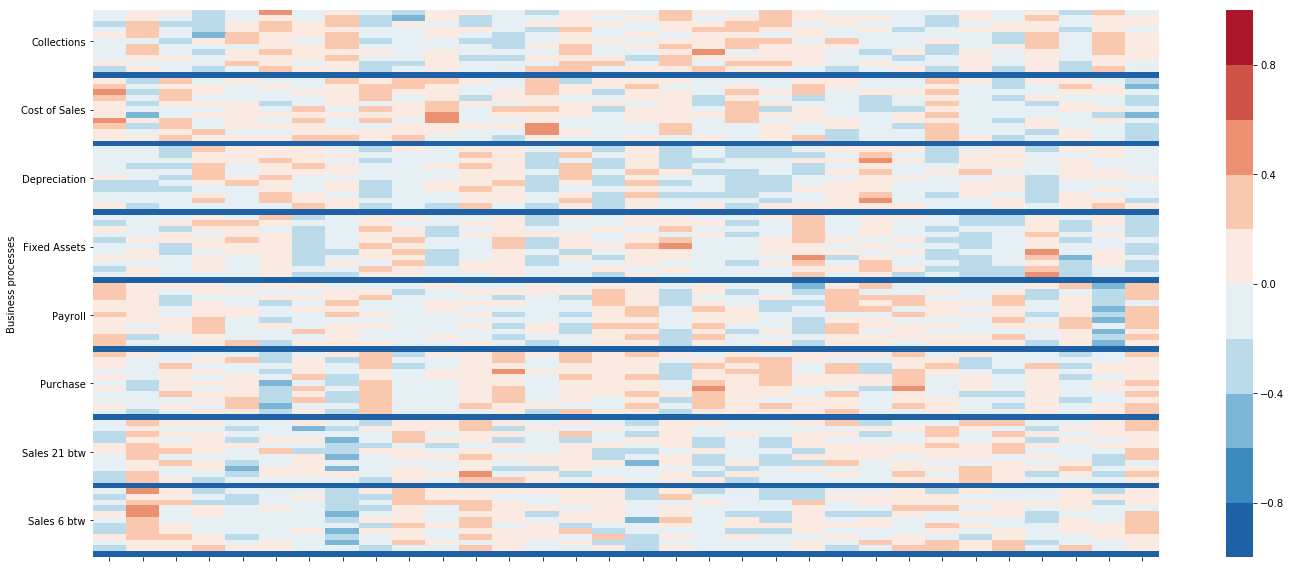

In [9]:
# sm_embs = embs.head(50).sort_values("GroundTruth")
title="vectors_vis_batch128_0905"
import matplotlib.ticker as ticker
plt.figure(figsize=(20, 8))
t_ax = sns.heatmap(list(sm_embs_bad["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 10))
frame1 = plt.gca()
frame1.axes.set_xlabel('')
frame1.axes.set_ylabel('Business processes')
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels(list(sm_embs["GroundTruth"].dropna().unique()), rotation='horizontal')
frame1.axes.yaxis.set_major_locator(ticker.FixedLocator([ns/2+it*(ns+1) for it in range(8)]))
plt.rc('axes', titlesize=18)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
plt.tight_layout()
plt.savefig("img/" + title, dpi=140, pad_inches=0.01)

In [46]:
def plotVectors(df, title="Vectors"):
    import matplotlib.ticker as ticker
    plt.rc('axes', titlesize=18)  # fontsize of the x and y titles
    plt.rc('axes', labelsize=18)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
    plt.figure(figsize=(20, 8))
    t_ax = sns.heatmap(list(df["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 10))
    frame1 = plt.gca()
    frame1.axes.set_xlabel('')
    frame1.axes.set_ylabel('Business processes')
    frame1.axes.xaxis.set_ticklabels([])
    ns = np.where(df.GroundTruth.values==None)[0][0]
    frame1.axes.yaxis.set_ticklabels(list(df["GroundTruth"].dropna().unique()), rotation='horizontal')
    frame1.axes.yaxis.set_major_locator(ticker.FixedLocator([ns/2+it*(ns+1) for it in range(8)]))
    postfix = "_emb_size"+str(len(df["Emb"].values[0]))+"samples_per_group"+str(ns)
    plt.tight_layout()
    plt.savefig(cur_path+"img/" + title+postfix, dpi=140, pad_inches=0.01)

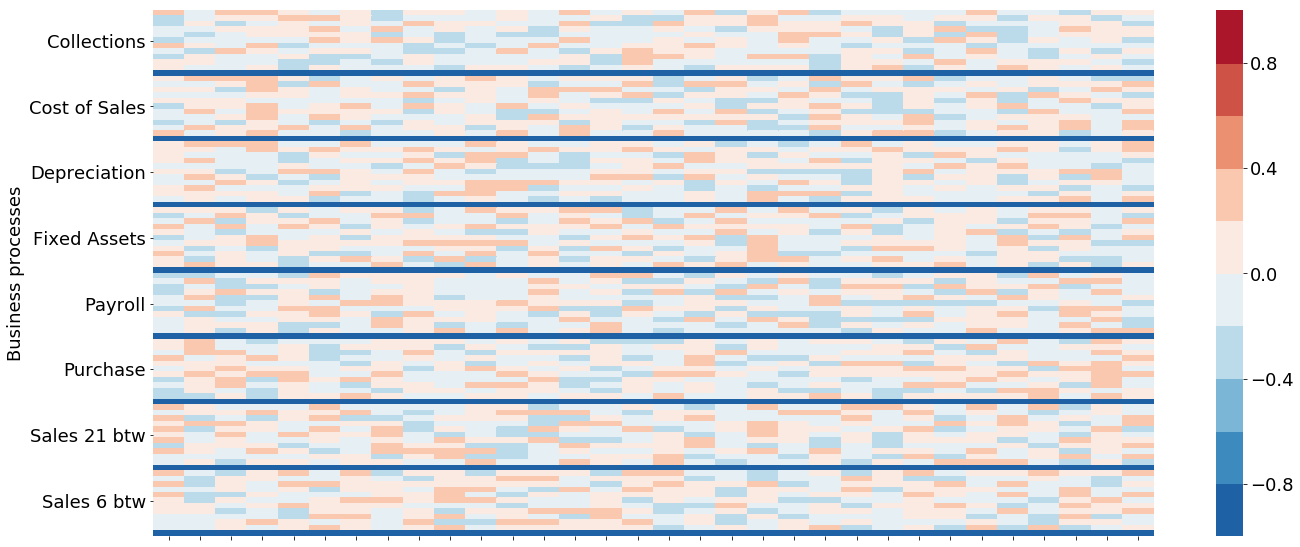

In [51]:
plotVectors(sm_embs_bad, title="BadVectors")

For group  Payroll Disbursement  is not enough samples...
For group  Tax disbursement  is not enough samples...


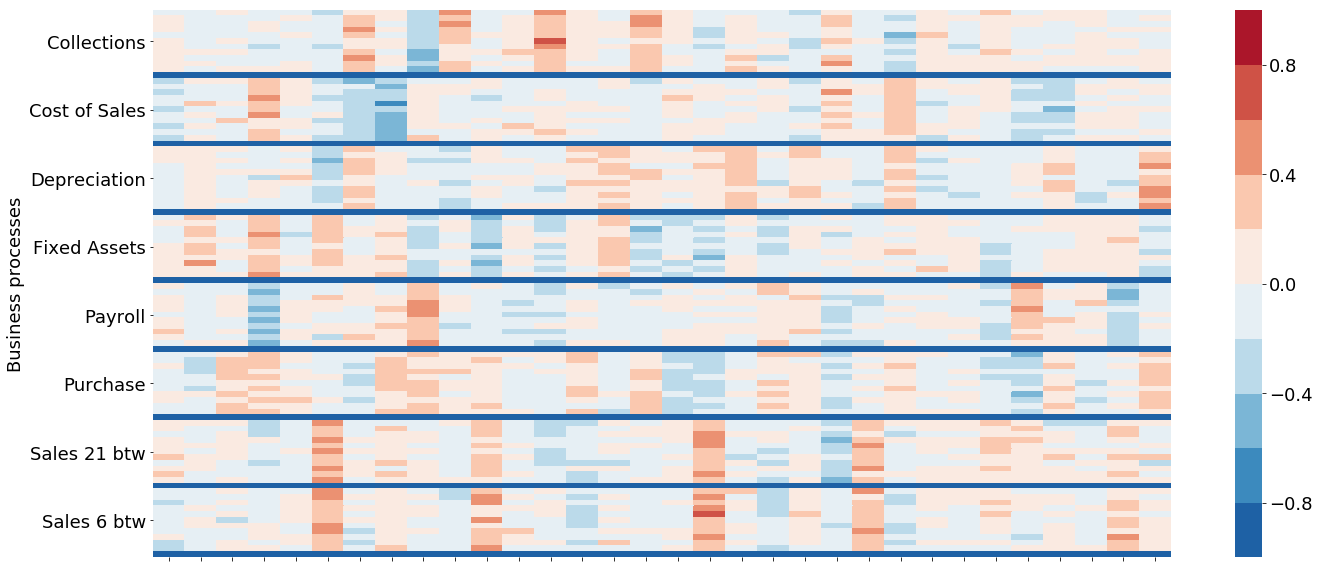

In [17]:
def groupVectors(df, how="median", samples_per_group=11, print_info=False):
    means = dict()
    pretty_vectors = pd.DataFrame(columns=list(df))
    for name, group in df.groupby("GroundTruth"):
        if group.shape[0] > samples_per_group:
            cur_data = group.copy()
            if how=="mean":
                means[name] = np.mean(group["Emb"].values, axis=0)
            elif how=="median":
                means[name]=np.median(group["Emb"].values.tolist(), axis=0)
            elif how=="random":
                means[name]=group["Emb"].values[0]
            cur_data["Similarity"] = cur_data["Emb"].apply(lambda x: 
                                                     cosine_similarity(X=means[name].reshape(1, -1), Y=x.reshape(1, -1)))
            cur_data.sort_values("Similarity", ascending=False, axis=0, inplace=True)
            if print_info:
                print("-----"+name+"-----")
                print("Highest similarity: \n", cur_data.Similarity.head(2), "\nLowest similarity: \n", cur_data.Similarity.tail(2))
            app = cur_data.head(samples_per_group).copy()
            pretty_vectors = pretty_vectors.append(app, sort=True).append(pd.DataFrame(
                {"ID": 0, "Emb": [[-2]*32], "GroundTruth": None}), sort=False)
        else:
            print("For group ", name, " is not enough samples...")
    return pretty_vectors

plotVectors(groupVectors(embs, how="mean"), title="prettyVectorsMean")

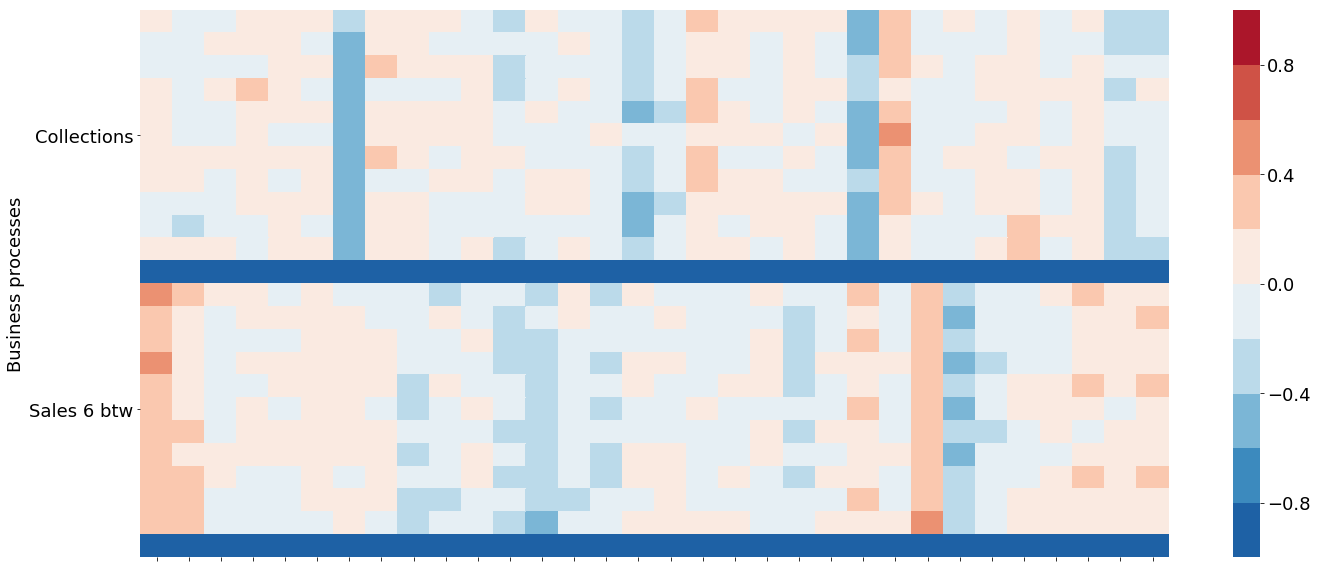

In [6]:
plotVectors(groupVectors(embs_bad, how="median", subset=["Collections", "Sales 6 btw"]), title="MarcelTest")

## Clustering score

### V-Score

In [19]:
from sklearn.metrics import v_measure_score

In [20]:
cl_data = cl_Agglomerative(embs, 9)

First row of Data: 
 [-0.09786817 -0.23157203 -0.14156301  0.27305391 -0.13673471  0.12182818
  0.03722091  0.21136773 -0.12387206 -0.19726457  0.20835899  0.15486643
  0.16628319  0.21206275  0.06521697  0.28254586 -0.32105815 -0.28338763
  0.0989148   0.19796106  0.10989743 -0.1214981  -0.12578729  0.16943938
 -0.17804816 -0.01854709 -0.14689441  0.06983992 -0.20140049 -0.23896381
 -0.12752278 -0.08987135]


In [21]:
str_labels = list(cl_data.GroundTruth.unique())
real_labels = dict(zip(str_labels, range(len(str_labels))))
real_labels

{'Purchase': 0,
 'Sales 21 btw': 1,
 'Cost of Sales': 2,
 'Fixed Assets': 3,
 'Tax disbursement': 4,
 'Payroll': 5,
 'Payroll Disbursement': 6,
 'Depreciation': 7,
 'Sales 6 btw': 8,
 'Collections': 9}

In [22]:
cl_data["true_labels"] = cl_data.GroundTruth.apply(lambda x: real_labels[x])

In [14]:
cl_data.head(3)

,ID,Emb,GroundTruth,label
0,1,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase,6
1,3,"[-0.19971998, 0.38667735, 0.02246202, 0.154739...",Sales 21 btw,8
2,4,"[0.16549358, -0.20079182, 0.38595855, -0.10701...",Cost of Sales,0


In [23]:
v_measure_score(cl_data.true_labels.values, cl_data.label.values)

0.8999157376051626

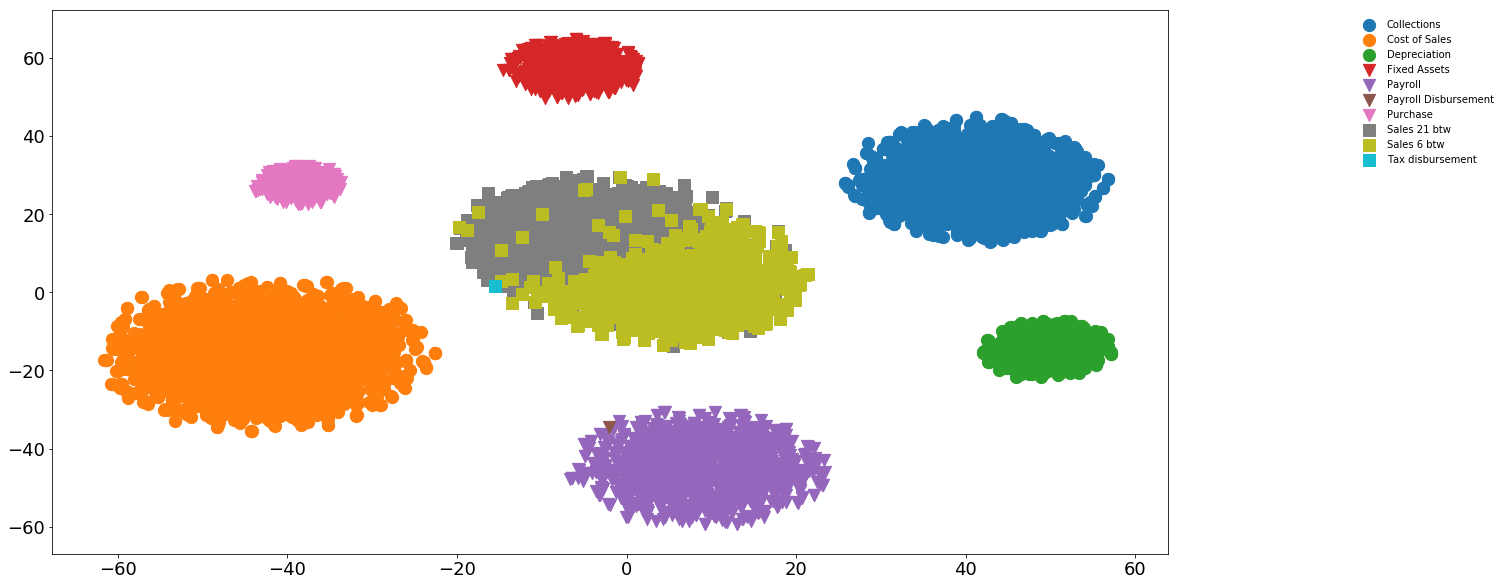

In [24]:
plot_tSNE(cl_data, legend_title="GroundTruth", title=None)

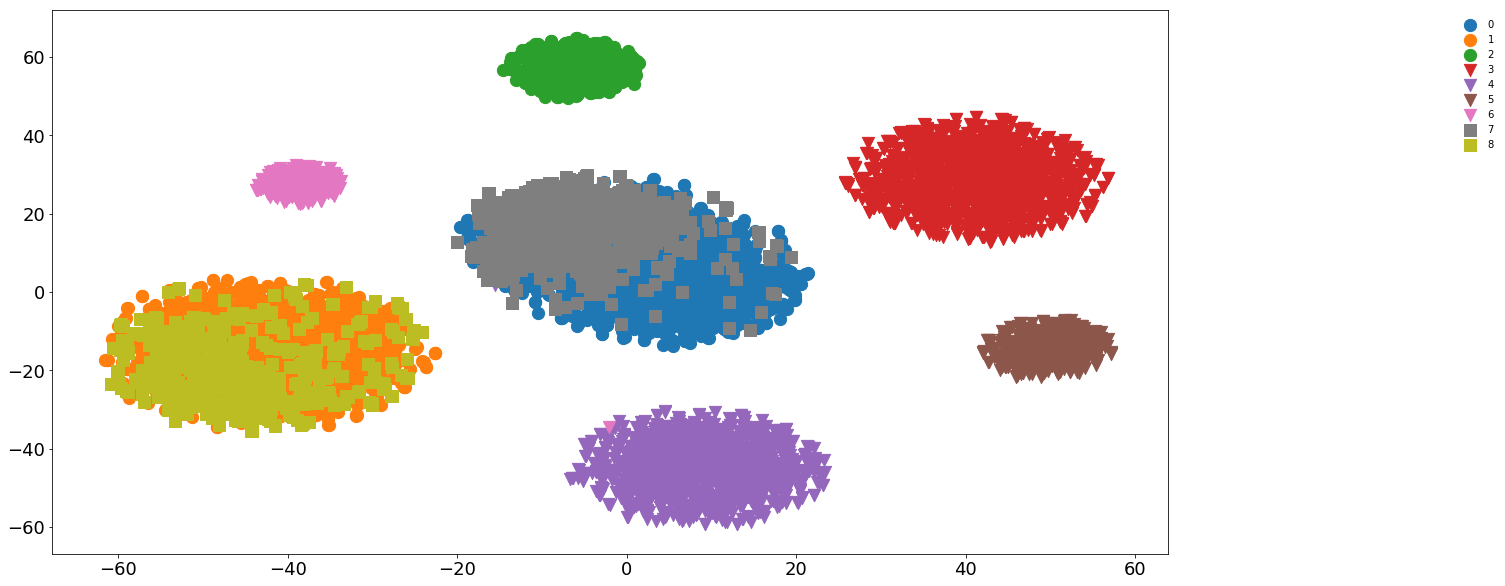

In [28]:
plot_tSNE(cl_data, legend_title="label", title=None)

In [34]:
def plot_PCA(fsn_embs, title="PCA", folder="", legend_title="GroundTruth", rand_state=1):
    import os
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    pca = PCA(n_components=2)
    embdf = pd.DataFrame(list(map(np.ravel, fsn_embs["Emb"])))
    embed_tsne = pca.fit_transform(embdf)
    fsn_embs["x"] = pd.Series(embed_tsne[:, 0])
    fsn_embs["y"] = pd.Series(embed_tsne[:, 1])
    markers = ["o", "v", "s"]
    cur_m = 0
    plt.clf()
    n_gr = 0
    for name, group in fsn_embs.groupby(legend_title):
        n_gr += 1
        if n_gr > 3:
            cur_m = cur_m + 1 if len(markers) - 1 > cur_m else 0
            n_gr = 0
        plt.scatter(group["x"].values, group["y"].values, s=150, marker=markers[cur_m], label=name)
    plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", frameon=False, markerscale=1)
    if legend_title == "GroundTruth":
        plt.title("Embeddings visualisation with PCA, Ground Truth")
    elif legend_title == "label":
        plt.title("Embeddings visualisation with PCA, predicted labels")

    if title is not None and isinstance(title, str):
        plt.tight_layout()
        postfix = ""
        if folder == "":
            postfix = "_" + "batch" + str(BATCH_SIZE) \
                      + "_emb" + str(EMBD_SIZE) \
                      + "_walks" + str(WALKS_PER_NODE) \
                      + "_TFsteps" + str(STEPS)
        plt.savefig(folder + "img/" + title + postfix, dpi=140, pad_inches=0.01)

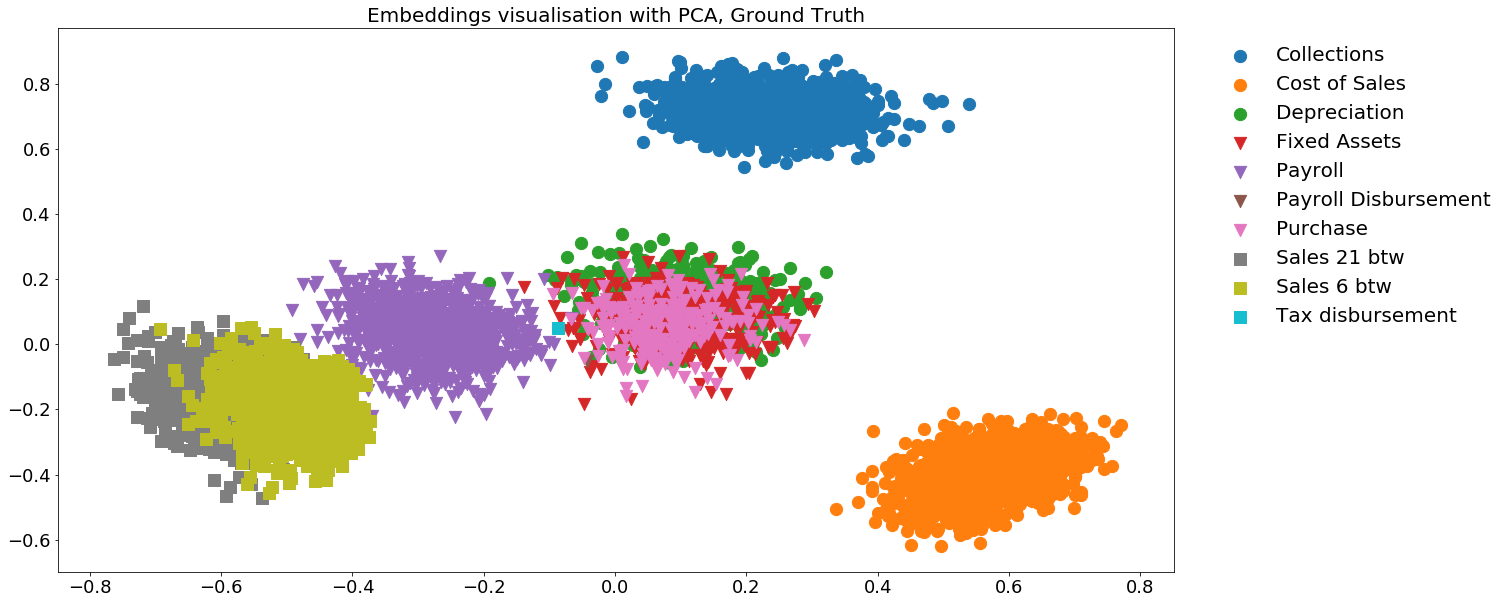

In [36]:
set_font(20)
plot_PCA(cl_data, legend_title="GroundTruth", title=None)

In [ ]:
from collections import Counter
pred_labels = sorted(list(cl_data.label.unique()))
true_labels = sorted(list(cl_data.GroundTruth.unique()))
confuse_me = dict().fromkeys(pred_labels, dict().fromkeys(true_labels, 0))
for name, group in cl_data.groupby("label"):
    cnt = dict(Counter(group.GroundTruth.values.tolist()))
    tmp = confuse_me[name].copy()
    tmp.update(cnt)
    confuse_me[name]=tmp
confuse_me

# Word count for FAs

In [6]:
d = upload_data("Simulation/FSN_Data.db", limit=None)
d.head(4)
journal_entries = None
if journal_entries is None:
    d = prepare_data(d)
else:
    YOUR_DATAFRAME = pd.DataFrame.from_dict(journal_entries)
    YOUR_DATAFRAME.columns = ['ID', 'FA_Name', 'Debit', 'Credit']
    d = prepare_data(YOUR_DATAFRAME, split=False)
d.head(4)

Original shape of DataFrame is  (60705, 4)
Deleted all NaNs and Strings values from 'Value' column:  (60705, 4)
Before merging FAs columns titles are:  ['ID', 'Name', 'FA_Name', 'Value', 'Debit', 'Credit']
After merging FAs columns titles are:  ['ID', 'FA_Name', 'Credit', 'Debit', 'Name', 'Value']  shape is  (60605, 6)
After normalization shape of DataFrame is  (60605, 7)
Final shape of DataFrame is  (52232, 8)


,ID,Signature,FA_Name,Credit,Debit,Name,Value,from
0,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_hvlh,0.003932,0.0,NoisyLeftFA_hvlh_9,-0.871915,True
1,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_iawn,0.000292,0.0,NoisyLeftFA_iawn_9,-0.064821,True
2,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_mzjd,0.003658,0.0,NoisyLeftFA_mzjd_9,-0.811047,True
3,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",OtherExpenses,0.401357,0.0,OtherExpenses_9,-89.000000,True


In [39]:
w_cnt = d.merge(cl_data, on="ID")

In [59]:
w_cnt["amount"] = w_cnt["Value"].apply(lambda x: abs(x)*100)

In [11]:
d.Signature.head(2).values

array(["([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA_iawn', 0.00029), ('NoisyLeftFA_mzjd', 0.00366), ('OtherExpenses', 0.40136), ('PersonnelExpenses', 0.25705), ('PrepaidExpenses', 0.33371)], [('TradePayables', 1.0)])",
       "([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA_iawn', 0.00029), ('NoisyLeftFA_mzjd', 0.00366), ('OtherExpenses', 0.40136), ('PersonnelExpenses', 0.25705), ('PrepaidExpenses', 0.33371)], [('TradePayables', 1.0)])"],
      dtype=object)

In [90]:
w_cnt

,ID,Signature,FA_Name,Credit,Debit,Name,Value,from,Emb,GroundTruth,label,amount
0,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_hvlh,0.003932,0.000000,NoisyLeftFA_hvlh_9,-0.871915,True,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase,6,87.191468
1,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_iawn,0.000292,0.000000,NoisyLeftFA_iawn_9,-0.064821,True,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase,6,6.482113
2,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",NoisyLeftFA_mzjd,0.003658,0.000000,NoisyLeftFA_mzjd_9,-0.811047,True,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase,6,81.104704
3,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",OtherExpenses,0.401357,0.000000,OtherExpenses_9,-89.000000,True,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase,6,8900.000000
4,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",PersonnelExpenses,0.257049,0.000000,PersonnelExpenses_9,-57.000000,True,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase,6,5700.000000
5,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",PrepaidExpenses,0.333712,0.000000,PrepaidExpenses_9,-74.000000,True,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase,6,7400.000000
6,1,"([('NoisyLeftFA_hvlh', 0.00393), ('NoisyLeftFA...",TradePayables,0.000000,1.000000,TradePayables_9,221.747783,False,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase,6,22174.778284
7,3,"([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...",NoisyLeftFA_tlhk,0.002741,0.000000,NoisyLeftFA_tlhk_7,-1.931609,True,"[-0.19971998, 0.38667735, 0.02246202, 0.154739...",Sales 21 btw,8,193.160920
8,3,"([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...",NoisyRightFA_fuka,0.000000,0.003406,NoisyRightFA_fuka_7,2.400248,False,"[-0.19971998, 0.38667735, 0.02246202, 0.154739...",Sales 21 btw,8,240.024790
9,3,"([('NoisyLeftFA_tlhk', 0.00274), ('Revenue', 0...",NoisyRightFA_gsbk,0.000000,0.003416,NoisyRightFA_gsbk_7,2.407134,False,"[-0.19971998, 0.38667735, 0.02246202, 0.154739...",Sales 21 btw,8,240.713406


Current cluster label is  0
Left ---> [('Inventory', 1661, 82192332.2998623), ('NoisyLeftFA_tbxa', 17, 3109.6849557031705), ('NoisyLeftFA_wpra', 15, 1768.468669240795), ('NoisyLeftFA_abxe', 14, 1625.9739830557226)]
Right ---> [('CostOfSales', 1661, 82258798.73615825), ('NoisyRightFA_bjhu', 20, 2538.076344313104), ('NoisyRightFA_csix', 17, 1250.4708123303094), ('NoisyRightFA_rrxn', 16, 1527.3304372659811)]


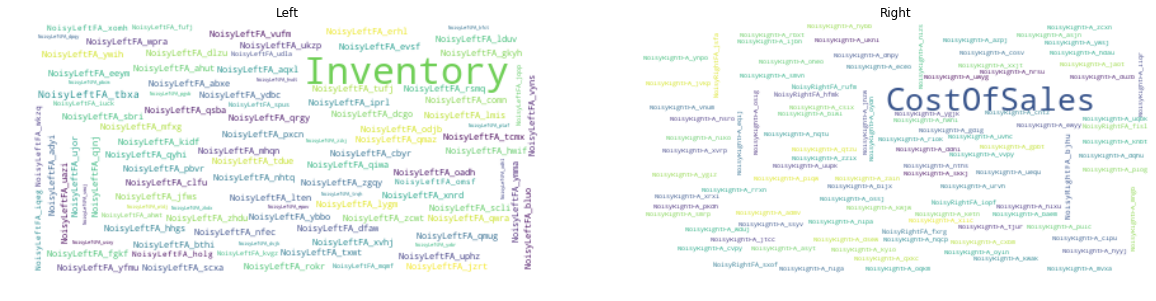

Current cluster label is  1
Left ---> [('Revenue', 598, 29855800.0), ('Tax', 598, 4023857.330460882), ('NoisyLeftFA_vywa', 7, 407.02733740925163), ('NoisyLeftFA_evsf', 7, 542.2126966193772)]
Right ---> [('TradeReceivables', 598, 33896815.1903523), ('NoisyRightFA_kfix', 8, 1187.7900593814434), ('NoisyRightFA_cots', 8, 562.9852922872243), ('NoisyRightFA_ekku', 8, 1321.6122454378487)]


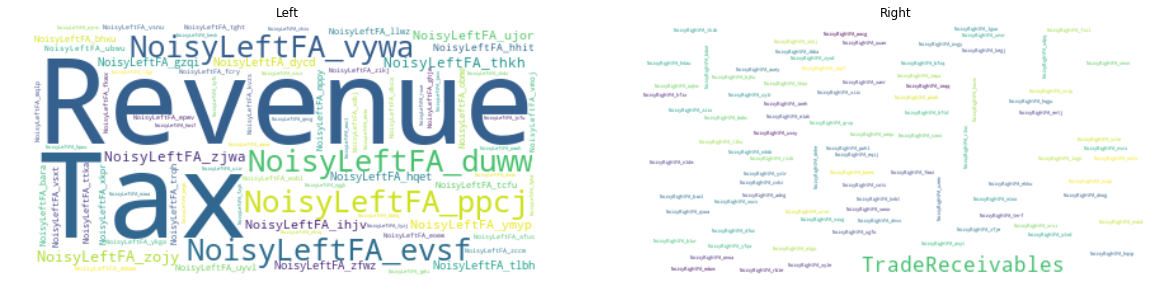

Current cluster label is  2
Left ---> [('Revenue', 815, 40818000.0), ('Tax', 815, 5449318.915404374), ('NoisyLeftFA_xxnw', 9, 655.1292302310839), ('NoisyLeftFA_gilw', 8, 873.8311976474953)]
Right ---> [('TradeReceivables', 815, 46296777.14136057), ('NoisyRightFA_ejyk', 10, 1113.118024213949), ('NoisyRightFA_ktie', 9, 1155.6709261837807), ('NoisyRightFA_ccfv', 9, 1466.7564175120508)]


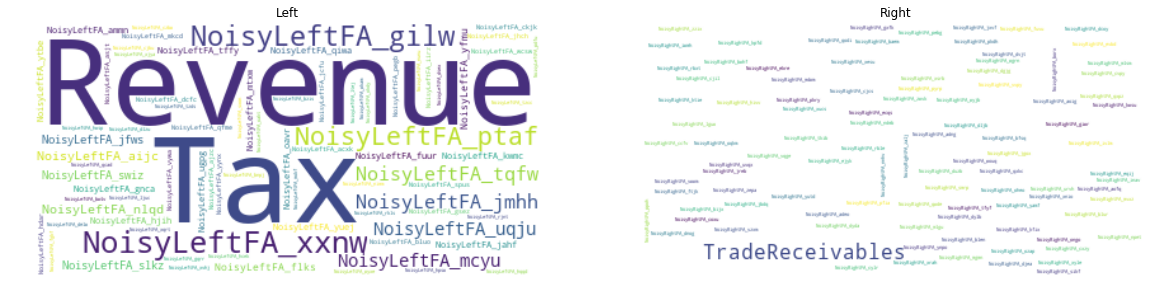

Current cluster label is  3
Left ---> [('EBPayables', 1060, 125359340.36614928), ('Tax', 1060, 33390000.0), ('NoisyLeftFA_qpca', 14, 1122.7101560256901), ('NoisyLeftFA_bixz', 11, 776.2709259759044)]
Right ---> [('PersonnelExpenses', 1060, 159215265.6584286), ('NoisyRightFA_sajy', 14, 1303.7044787742807), ('NoisyRightFA_uqbk', 13, 775.8968899458698), ('NoisyRightFA_vqge', 13, 1210.6407241201368)]


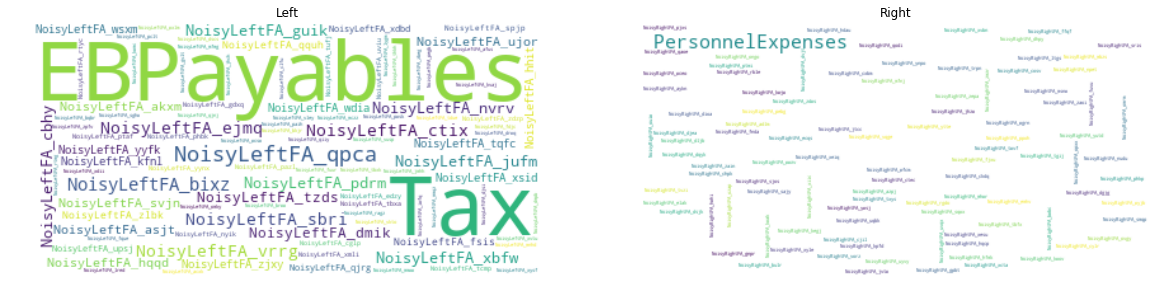

Current cluster label is  4
Left ---> [('TradeReceivables', 1172, 66115272.10944055), ('NoisyRightFA_urvh', 21, 2541.3172762118957), ('NoisyRightFA_mdwm', 19, 2136.2887255555556), ('NoisyRightFA_evbd', 18, 1434.8045696898278)]
Right ---> [('Cash', 1172, 66673757.89423147)]


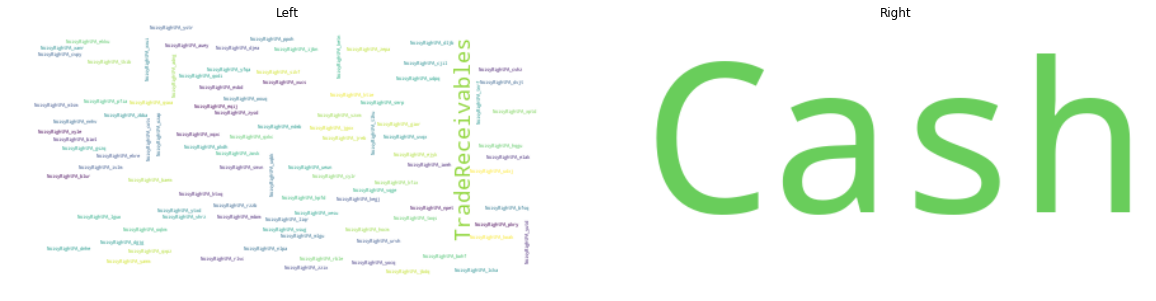

Current cluster label is  5
Left ---> [('FixedAssets', 410, 2210940.140707148), ('NoisyLeftFA_uioj', 6, 95.04441924788154), ('NoisyLeftFA_kzqt', 6, 102.2235584294111), ('NoisyLeftFA_dmik', 6, 83.81327447534765)]
Right ---> [('DepreciationExpense', 410, 2214200.0), ('NoisyRightFA_phkp', 7, 114.77276275201008), ('NoisyRightFA_kowk', 7, 129.68422632897773), ('NoisyRightFA_wduj', 6, 54.67485398334927)]


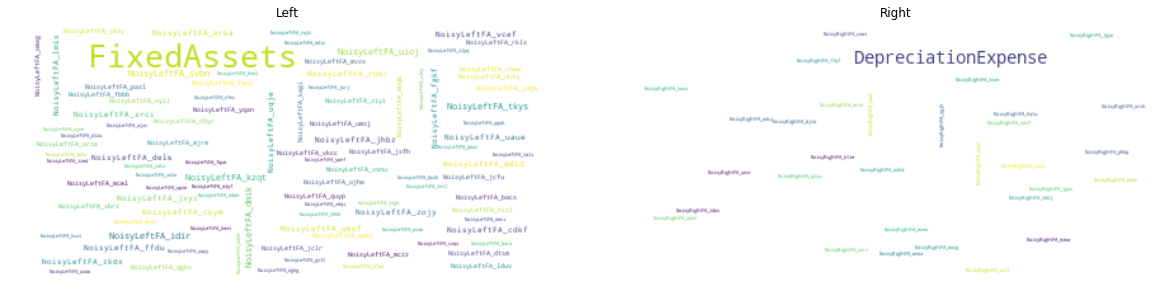

Current cluster label is  6
Left ---> [('OtherExpenses', 236, 1201100.0), ('PersonnelExpenses', 236, 1204800.0), ('PrepaidExpenses', 236, 1162100.0), ('NoisyLeftFA_xdbd', 4, 88.83602936349848)]
Right ---> [('TradePayables', 236, 3571454.0159209436), ('NoisyRightFA_ital', 5, 214.06716628209273), ('NoisyRightFA_buxk', 4, 92.1717426924935), ('NoisyRightFA_xyle', 4, 137.31110593451945)]


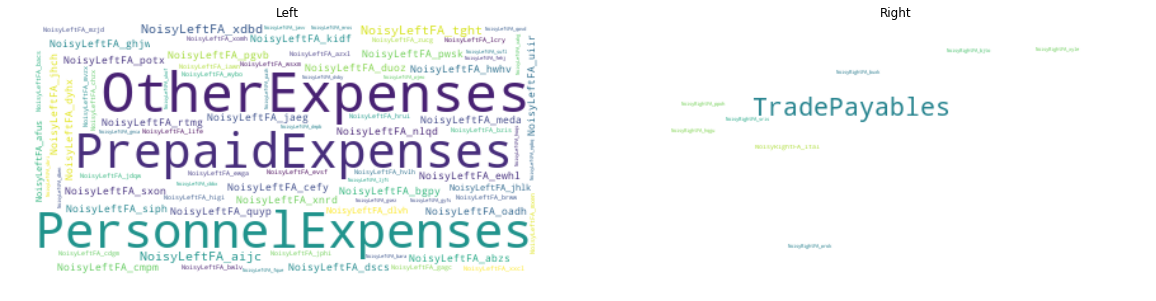

Current cluster label is  7
Left ---> [('TradePayables', 430, 2353200.0), ('NoisyLeftFA_vzfa', 7, 109.98534307047811), ('NoisyLeftFA_bsjg', 7, 150.36214520115774), ('NoisyLeftFA_tlbh', 6, 71.72079256944667)]
Right ---> [('FixedAssets', 430, 2357422.89149614), ('NoisyRightFA_dnhe', 10, 92.35911484288162), ('NoisyRightFA_wocg', 8, 112.73574488322362), ('NoisyRightFA_lgjx', 8, 197.53494953364918)]


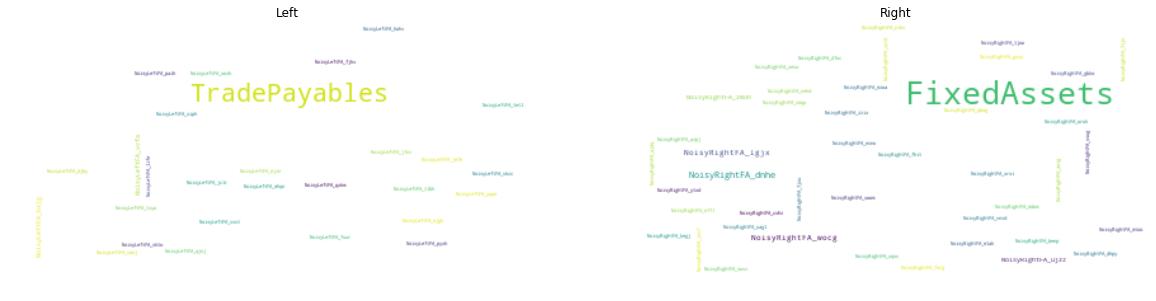

Current cluster label is  8
Left ---> [('Revenue', 460, 22586300.0), ('Tax', 460, 3111770.1766418116), ('NoisyLeftFA_gdxq', 6, 573.7293859477364), ('NoisyLeftFA_bzis', 6, 693.0541398464485)]
Right ---> [('TradeReceivables', 460, 25688826.30736379), ('NoisyRightFA_urvh', 8, 1120.8896192267066), ('NoisyRightFA_xxui', 7, 966.0812290462302), ('NoisyRightFA_ystr', 7, 1111.1661537783566)]


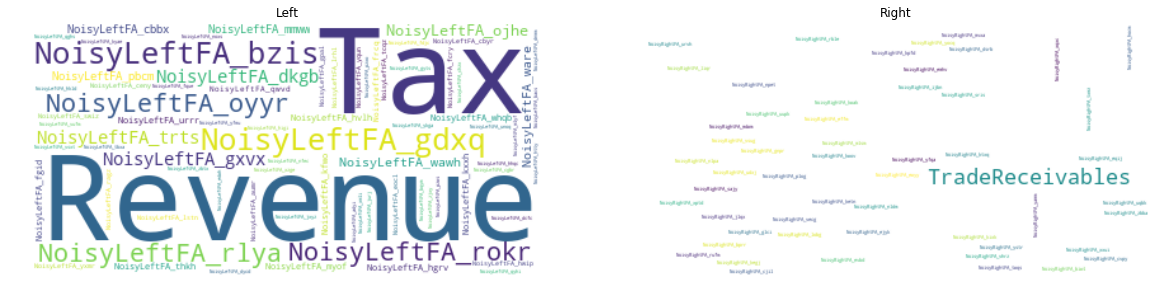

In [106]:
def findMostCommonFAs(df, labels_column="label", words_column="FA_Name", amount_column="amount", sort_mode="freq", n_top=2, vis=False):
    if vis:
        from wordcloud import WordCloud
    for name, group in df.groupby(labels_column):
        print("Current cluster label is ", name)
        cur_data = group.groupby(words_column, as_index=False)[amount_column].agg(sum)
        fa_amounts = dict(zip(cur_data[words_column].values, cur_data[amount_column].values))
        text = {"Left": [(item[0], item[1], fa_amounts[item[0]]) for item in Counter(group[group["from"] == True][words_column].values).items()], 
                "Right": [(item[0], item[1], fa_amounts[item[0]]) for item in Counter(group[group["from"] == False][words_column].values).items()]}
        if vis:
            i = 1
            fig = plt.figure()  
        for key, data in text.items():
            if sort_mode == "freq":
#             Take the most frequent FA names
                output = sorted(data, key=lambda d: -d[1])
                to_vis = [(item[0], item[1]) for item in output]
            elif sort_mode == "amount":
                output = sorted(data, key=lambda d: -d[2])
                to_vis = [(item[0], item[2]) for item in output]
            print(key, "--->", output[:n_top])
            if vis:
                ax = fig.add_subplot(1,2,i)
                i+=1
                ax.set_title(key)
                wc = WordCloud(background_color="white", repeat=False, relative_scaling=0.75, max_words=100)
                wc.generate_from_frequencies(dict(to_vis))
                ax.axis("off")
                ax.imshow(wc, interpolation="bilinear")
        if vis:
            plt.show()
# ----
findMostCommonFAs(w_cnt, "label", "FA_Name", sort_mode="freq", vis=True, n_top=4)

Chapter 3 focuses on the theoretical aspects of our approach for converting original FSN into interactive one by using representation learning techniques and further clustering in latent space. It is arranged as follows. First of all, we formulate the problem which we have to solve. Then we describe in detail our sampling strategy, state the reasons to modify the existing ones (which were highlighted in 1.3.2 ) and give a proof that our sampling strategy works correctly and as expected from the business point of view. Skip-Gram model section makes a bridge between the original network and its representation in latent space. An application of different clustering methods in embedding space is discussed later. Possible ways of further developments and conclusion are given in the last part of the current chapter.